<a href="https://colab.research.google.com/github/prachishete/DeepLearning/blob/main/CNN/DenoisingTechniques/00_Denoising_Median_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
#### In this series of experiments, we will see different techniques to remove the [Gaussian noise](https://en.wikipedia.org/wiki/Gaussian_noise#:~:text=Gaussian%20noise%2C%20named%20after%20Carl,known%20as%20the%20Gaussian%20distribution) from the image data
####In this 1st experiment, we will calculate the [Peak signal-to-noise ratio (PSNR)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) using [Median filter](https://en.wikipedia.org/wiki/Median_filter#:~:text=The%20median%20filter%20is%20a,edge%20detection%20on%20an%20image).

#[Median filter](https://en.wikipedia.org/wiki/Median_filter#:~:text=The%20median%20filter%20is%20a,edge%20detection%20on%20an%20image)
####The median filter is a non-linear digital filtering technique, often used to remove noise from an image or signal. 
####The main idea of the median filter is to run through the signal entry by entry, replacing each entry with the median of neighboring entries. The pattern of neighbors is called the "window", which slides, entry by entry, over the entire signal. For one-dimensional signals, the most obvious window is just the first few preceding and following entries, whereas for two-dimensional (or higher-dimensional) data the window must include all entries within a given radius or ellipsoidal region (i.e. the median filter is not a separable filter).


# **Download Dataset**
##[Medical Image Dataset](https://www.kaggle.com/datasets/parthplc/medical-image-dataset)
####The [Medical Image Dataset](https://www.kaggle.com/datasets/parthplc/medical-image-dataset) is available on Kaggle. This dataset consists of 120  dental X-rays images. We will split these images into Train (100 images), Validation (15 images) and Test (5 images).
####We will add [Gaussian noise](https://en.wikipedia.org/wiki/Gaussian_noise#:~:text=Gaussian%20noise%2C%20named%20after%20Carl,known%20as%20the%20Gaussian%20distribution) to these images and then apply the denoising technique to calculate the [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio).

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download parthplc/medical-image-dataset
! mkdir ~/medical-image-dataset
!unzip medical-image-dataset.zip -d medical-image-dataset

 69% 9.00M/13.0M [00:00<00:00, 16.2MB/s]
100% 13.0M/13.0M [00:00<00:00, 24.4MB/s]
Archive:  medical-image-dataset.zip
  inflating: medical-image-dataset/Dataset/1.jpg  
  inflating: medical-image-dataset/Dataset/10.jpg  
  inflating: medical-image-dataset/Dataset/100.jpg  
  inflating: medical-image-dataset/Dataset/101.jpg  
  inflating: medical-image-dataset/Dataset/102.jpg  
  inflating: medical-image-dataset/Dataset/103.jpg  
  inflating: medical-image-dataset/Dataset/104.jpg  
  inflating: medical-image-dataset/Dataset/105.jpg  
  inflating: medical-image-dataset/Dataset/106.jpg  
  inflating: medical-image-dataset/Dataset/107.jpg  
  inflating: medical-image-dataset/Dataset/108.jpg  
  inflating: medical-image-dataset/Dataset/109.jpg  
  inflating: medical-image-dataset/Dataset/11.jpg  
  inflating: medical-image-dataset/Dataset/110.jpg  
  inflating: medical-image-dataset/Dataset/111.jpg  
  inflating: medical-image-dataset/Dataset/112.jpg  
  inflating: medical-image-dataset/Dat

# **Import the libraries**
#### We will set the seed so that the initial random values set in the experiment will be same throughout the series. This will help in comparing the outputs as we will move from one experiment to next

In [ ]:
import random
import numpy as np
import tensorflow as tf

seed=7
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
#tf.config.experimental.enable_op_determinism()

# **Create training and testing arrays**

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
import cv2
from math import log10,sqrt

In [ ]:
def convert_images_to_array(images_folder, test=False):
    images = []
    for img_dir in images_folder:
        image = load_img(img_dir, color_mode='grayscale', target_size=(258, 540, 1))
        image = img_to_array(image).astype('float32') / 255.0
        images.append(image)
    return np.asarray(images)

In [ ]:
root_dir = '/content/medical-image-dataset/Dataset'
os.chdir(root_dir)

In [ ]:
train_images = sorted(os.listdir(root_dir))
X_train_full = convert_images_to_array(train_images)

In [ ]:
X_train_full.shape

(120, 258, 540, 1)

# **Add [Gaussian noise](https://en.wikipedia.org/wiki/Gaussian_noise#:~:text=Gaussian%20noise%2C%20named%20after%20Carl,known%20as%20the%20Gaussian%20distribution) to image dataset**

In [ ]:
def add_noise(image,mean,sigma):
    row,col,ch= image.shape
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy_img = image + gauss*0.3
    return noisy_img

In [ ]:
X_noised_full= []

for img in X_train_full:
    noisy_img= add_noise(img,0,1) #Mean 0 and sigma 1 for the Gaussian noise
    X_noised_full.append(noisy_img)

In [ ]:
X_noised_full= np.array(X_noised_full)

In [ ]:
X_noised_full.shape

(120, 258, 540, 1)

# **Visualize original & noisy images**

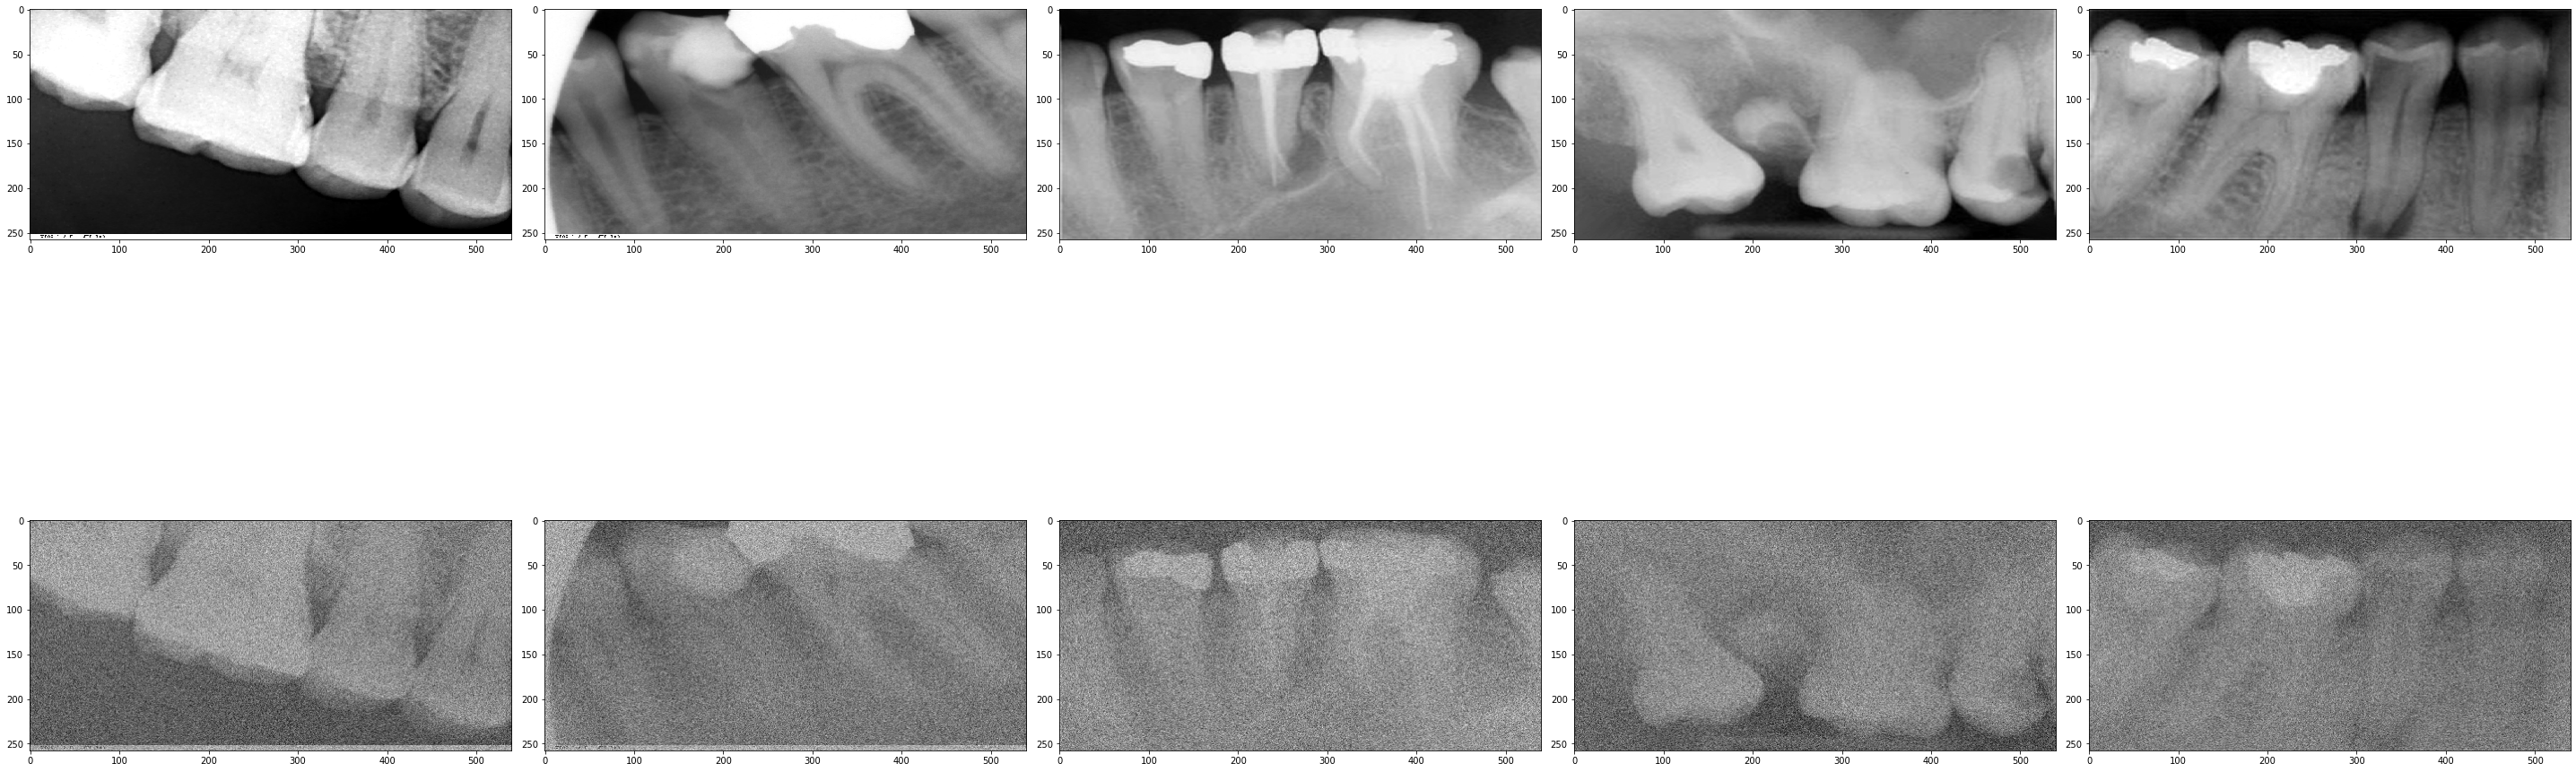

In [ ]:
f, ax = plt.subplots(2, 5)
#f.set_size_inches(10.5,7.5)
f.set_size_inches(40, 20)
for i in range(5):
        ax[0][i].imshow(np.reshape(X_train_full[i], (258, 540)), cmap='gray')
        ax[1][i].imshow(np.reshape(X_noised_full[i], (258, 540)), cmap='gray')
            
plt.tight_layout()


In [ ]:
def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(258, 540), cmap='gray')
    plt.show()

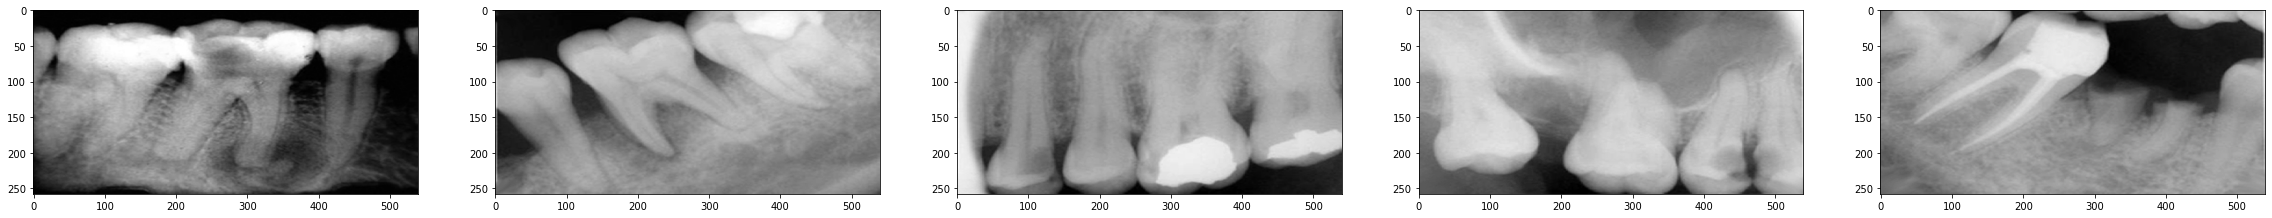

In [ ]:
show_img(X_train_full)

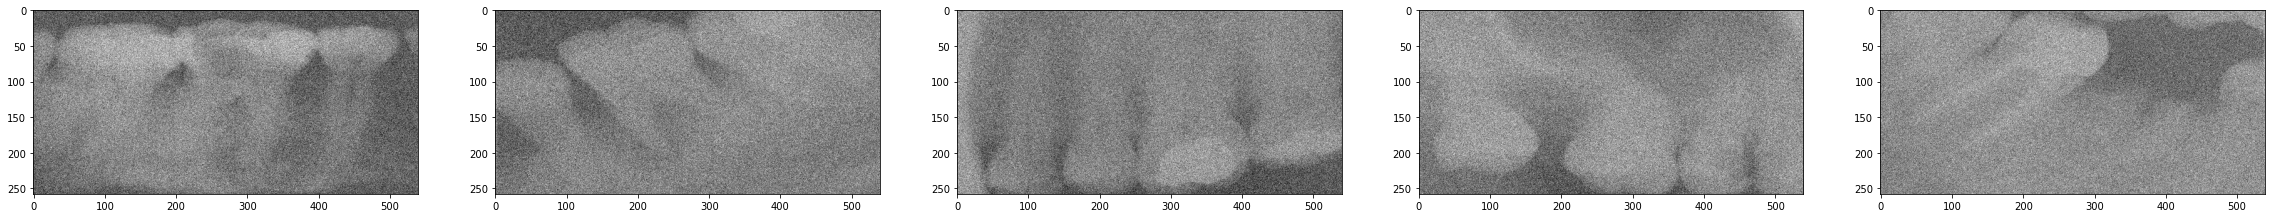

In [ ]:
show_img(X_noised_full)

# **Split the training set into train , validation and test set**

In [ ]:
X_train= X_noised_full[0:100]
X_val= X_noised_full[100:115]
X_test=X_noised_full[115:]

X_train_original= X_train_full[0:100]
X_val_original= X_train_full[100:115]
X_test_original=X_train_full[115:]

In [ ]:
X_train, Y_train = X_train, X_train_original
X_val, Y_val = X_val,X_val_original

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(100, 258, 540, 1)
(15, 258, 540, 1)
(5, 258, 540, 1)


# **Apply [Median filter](https://en.wikipedia.org/wiki/Median_filter#:~:text=The%20median%20filter%20is%20a,edge%20detection%20on%20an%20image)**

In [ ]:
median_img = []
for img in range(X_test.shape[0]):
    median= cv2.medianBlur(X_test[img].astype('float32'), (5)) 
    median_img.append(median)

median_img = np.array(median_img)

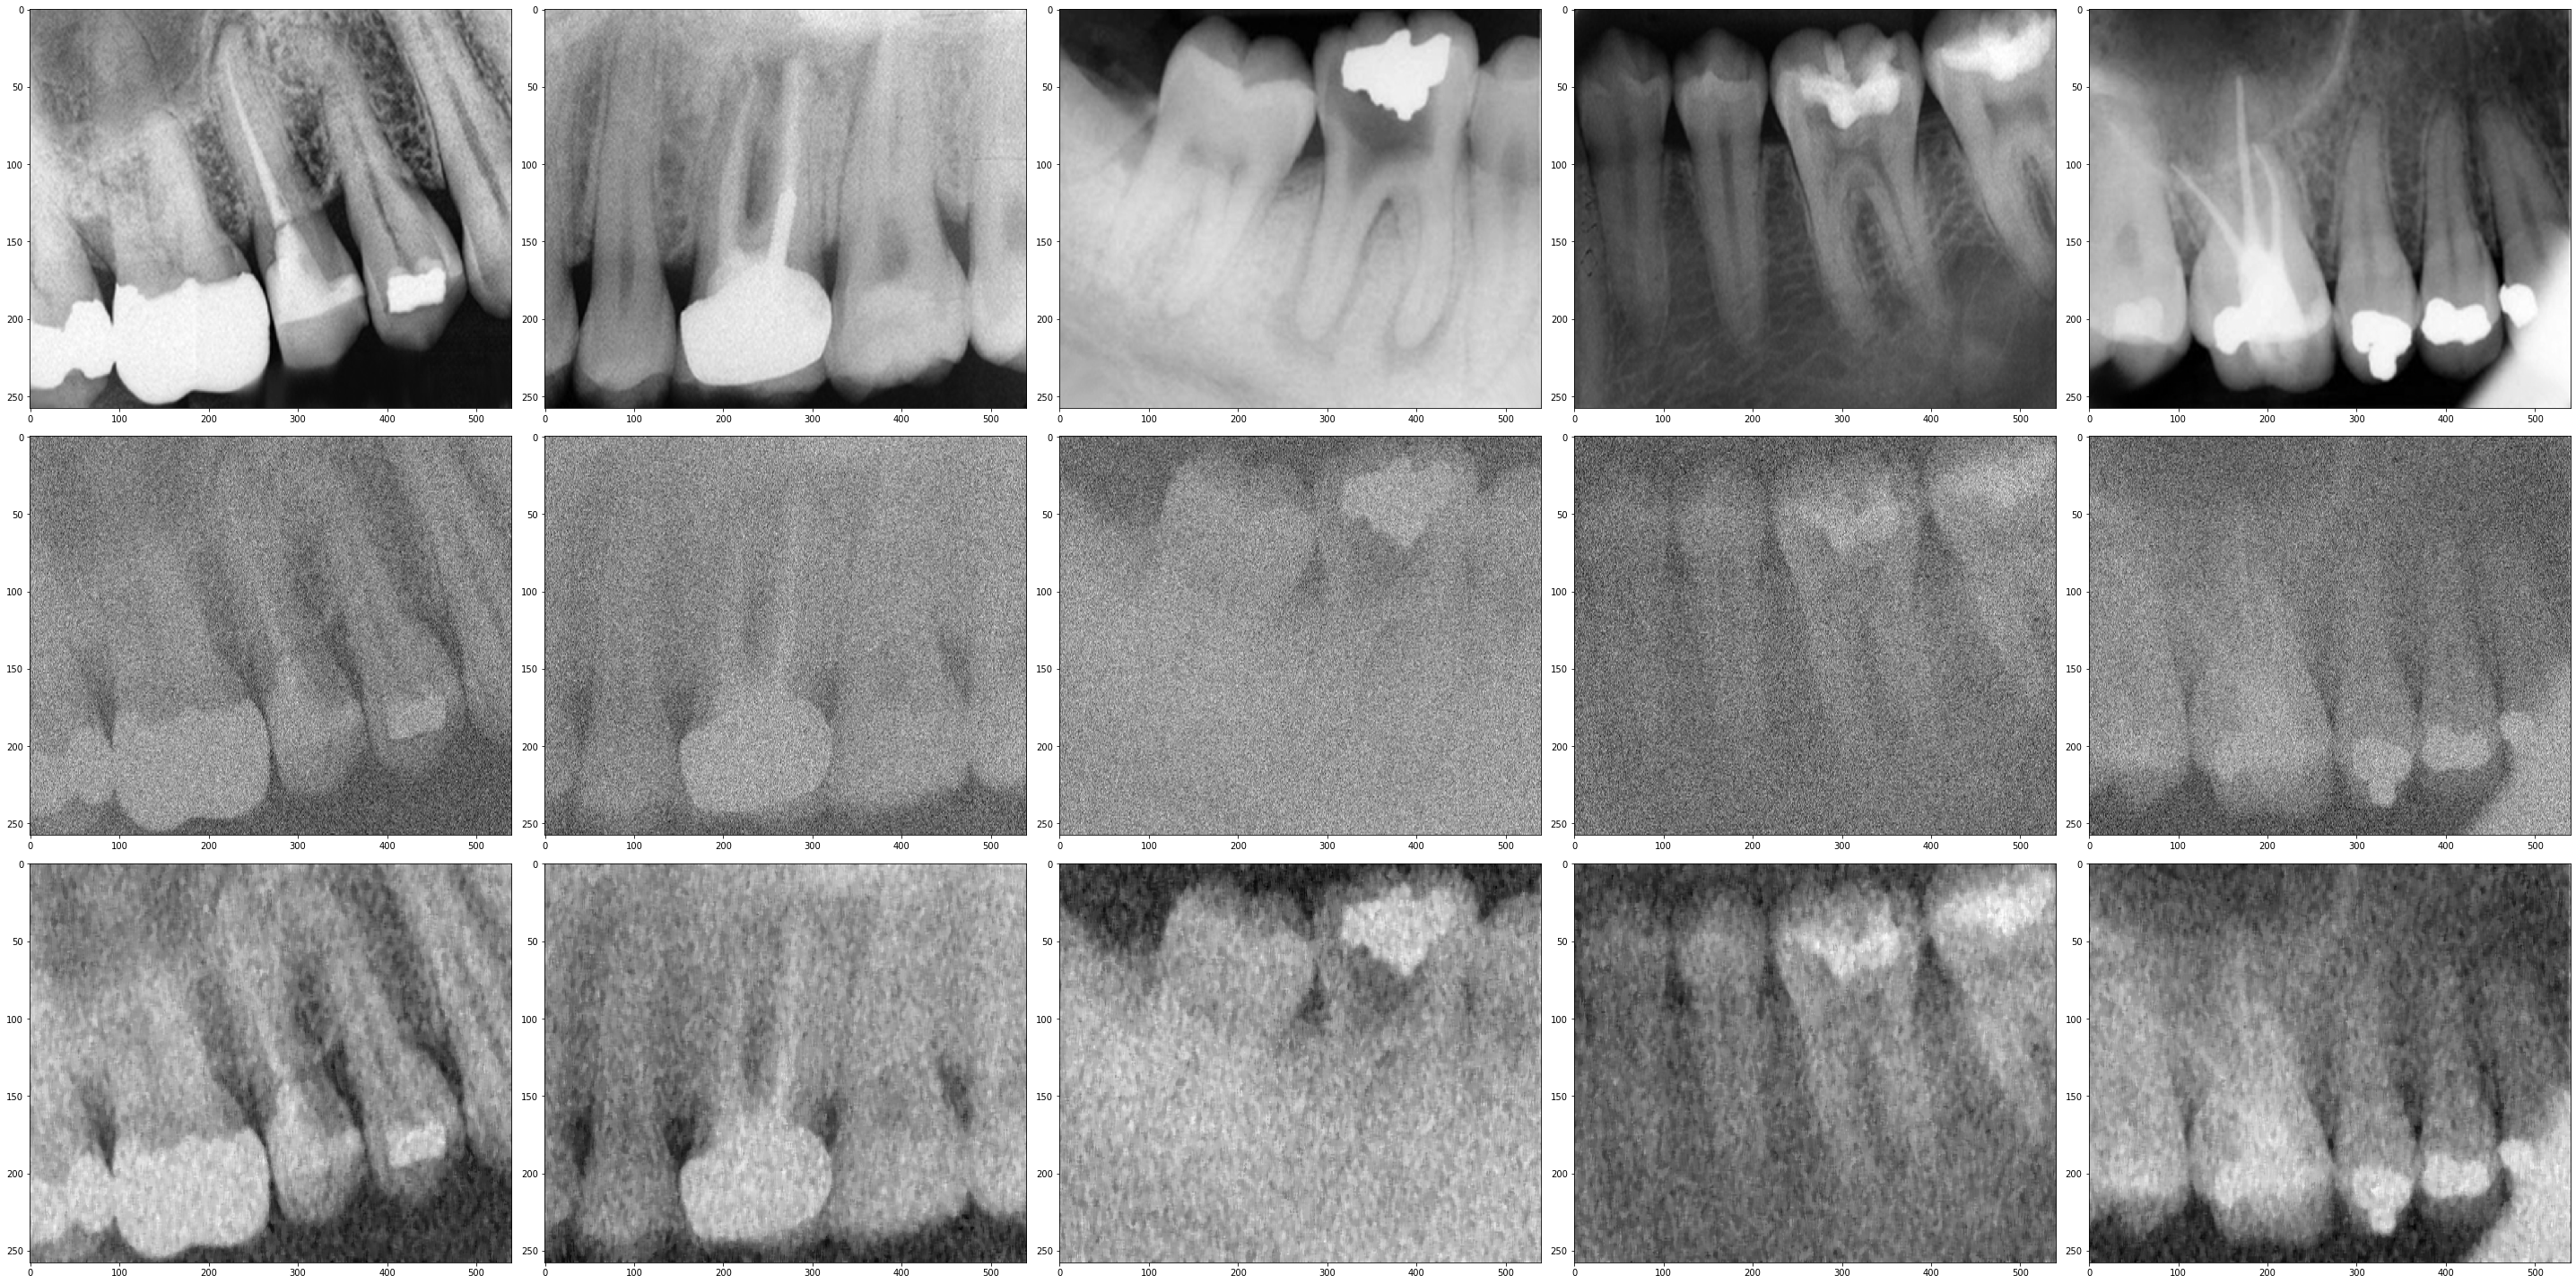

In [ ]:
f, ax = plt.subplots(3, 5)
f.set_size_inches(40, 20)
for i in range(5):
        ax[0][i].imshow(np.reshape(X_train_full[115+i], (258, 540)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(X_test[i], (258, 540)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(median_img[i], (258, 540)), aspect='auto', cmap='gray')
            
plt.tight_layout()

# **Calculate [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)**
Peak signal-to-noise ratio ([PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)) is an engineering term for the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation. Because many signals have a very wide dynamic range, PSNR is usually expressed as a logarithmic quantity using the decibel scale.

[PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) is commonly used to quantify reconstruction quality for images and video subject to lossy compression.

The PSNR (in dB) is defined as

\begin{aligned}{\mathit {PSNR}}&=10\cdot \log _{10}\left({\frac {{\mathit {MAX}}_{I}^{2}}{\mathit {MSE}}}\right)\\&=20\cdot \log _{10}\left({\frac {{\mathit {MAX}}_{I}}{\sqrt {\mathit {MSE}}}}\right)\\&=20\cdot \log _{10}({\mathit {MAX}}_{I})-10\cdot \log _{10}({\mathit {MSE}}).\end{aligned} 

In [ ]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
psnr = 0
for img in range(X_test.shape[0]):
    psnr = psnr + PSNR(np.reshape(X_test_original[img], (258, 540)), median_img[img]) 
    
psnr_final = psnr / X_test.shape[0]
print(psnr_final)

70.37246569984171


# **Conclusion**
####With the help of [Median filter](https://en.wikipedia.org/wiki/Median_filter#:~:text=The%20median%20filter%20is%20a,edge%20detection%20on%20an%20image), we could achieve the PSNR value as 70 dB. In the [next experiment](01_Denoising_AutoEncoder.ipynb), we will use CNN based Autoencoder and compare the PSNR value calculated on denoised  images generated by that.